In [1]:
import matplotlib

In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
import seaborn as sns
import time
import copy
import time

In [5]:
import os
import h5py

In [6]:
from numpy.fft import ifftshift, ifft2, fftshift, fft2
from numpy import exp, pi, mean, var, std, abs, sin, cos, sum

In [8]:
#filename = filenames[0]
filename = '/Volumes/jorgeamu/AFRL/dump1/hdf5_files/pristine_010000.hdf5'
f = h5py.File(filename, 'r')

In [9]:
# generate target
Uin = f['PUMP']['Data'][0,:,:]
N = 256
Lout = 10
Lin = 10e-3
deltax = 0.005
wvl = 0.532e-6
Dz = 10e3
nscreen = 10
kpow = 22/6
Rytov = 0.02
Np = 5

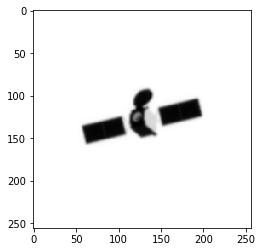

In [10]:
plt.imshow(abs(Uin), cmap='binary')

In [11]:
#phase screen parameter dictionary, hard-coded, WIP
phz_params_dict = {}
phz_params_dict['N'] = N
phz_params_dict['Lout'] = Lout
phz_params_dict['Lin'] = Lin
phz_params_dict['deltax'] = deltax
phz_params_dict['wvl'] = wvl
phz_params_dict['Dz'] = Dz
phz_params_dict['nscreen'] = nscreen
phz_params_dict['kpow'] = kpow
phz_params_dict['Rytov'] = Rytov
phz_params_dict['Np'] = Np

In [12]:
def ft_sh_phase_screen(Uin, phz_params_dict, genetic_code=None):
    N = phz_params_dict['N']
    Lout = phz_params_dict['Lout']
    Lin = phz_params_dict['Lin']
    deltax = phz_params_dict['deltax']
    wvl = phz_params_dict['wvl']
    Dz = phz_params_dict['Dz']
    nscreen = phz_params_dict['nscreen']
    kpow = phz_params_dict['kpow']
    Rytov = phz_params_dict['Rytov']
    Np = phz_params_dict['Np']

    k=2*pi/wvl
    nn=np.arange(-np.floor(N/2), np.floor(N/2))
    nx, ny = np.meshgrid(nn, nn)
    nsq = nx**2 + ny**2
    z=np.linspace(0, Dz, nscreen)

    deltaz=z[1]-z[0]
    deltaf=1/(N*deltax)

    # 0.312 is weird
    #Cn2=Rytov/(0.312 * k**(7/6) * Dz**(11/6))
    Cn2=Rytov/(1.2287075122549518 * k**(7/6) * Dz**(11/6))
    r0 = (.423*k**2*Cn2*Dz)**(-3/5) #check

    fx=nx*deltaf
    fy=ny*deltaf
    fsq=fx**2+fy**2

    Uin=Uin #np.ones([N, N])
    g=Uin

    # Generate 2x nscreens NxN arrays
    if genetic_code is None:
        genetic_code = np.zeros([N, N, nscreen, 2])
        for idx in range(nscreen-1):
            genetic_code[:,:,idx,0] = np.random.randn(N, N)
            genetic_code[:,:,idx,1] = np.random.randn(N, N)

    for idx in range(nscreen-1):
        #r0 = (.423*(k**2)*Cn2*deltaz)**(-3/5) # Constant Cn2
					 
        fm = 5.92/Lin/(2*pi)
        f0=1/Lout

        PSD_phi = 0.023 * r0**(-5/3) * exp(-(fsq/fm**2)) / (fsq + f0**2)**(kpow/2)
        PSD_phi[int(N/2),int(N/2)] = 0
        
        cnm = (genetic_code[:,:,idx,0] + 1j*genetic_code[:,:,idx,1]) * np.sqrt(PSD_phi)*deltaf
        #cnm = (np.random.randn(N, N) + 1j*np.random.randn(N, N) ) * np.sqrt(PSD_phi)*deltaf

        phz_hi = np.real(ifftshift(ifft2(ifftshift(cnm)))*(N*1)**2)
        phz_lo = np.zeros([N, N])
		  #phz_lo = subharmonics(Np, phz_hi)
        phz = phz_hi + phz_lo
		  
        Q2 = exp(-1j*pi**2*2*deltaz/k*fsq)
        G= Q2*fftshift(fft2(fftshift(g)))*deltax**2
        g = ifftshift(ifft2(ifftshift(G)))*(N*deltaf)**2
        g = exp(1j*phz) * g
		  
    Uout = g
    
    return Uout


In [13]:
Uout = ft_sh_phase_screen(Uin, phz_params_dict=phz_params_dict, genetic_code=None)

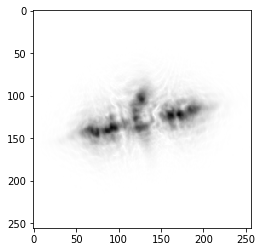

In [14]:
plt.imshow(abs(Uout), cmap='binary')

In [15]:
from skimage import io
from skimage.transform import resize, rotate
from skimage.draw import polygon, ellipse
from skimage.measure import compare_ssim

In [16]:
def generate_tile_indices(N, tiles_per_side):
    aList = [0]
    nom = 1
    for i in range(tiles_per_side):
        aList.append(int(nom*N/tiles_per_side))#-1)
        nom += 1
    
    anotherList = []
    for i in range(len(aList)-1):
        anotherList.append((aList[i], aList[i+1]))
    
    finalList = []
    for u in anotherList:
        for v in anotherList:
            finalList.append((u, v))
    
    return finalList

In [68]:
generate_tile_indices(N, 4)

[((0, 64), (0, 64)),
 ((0, 64), (64, 128)),
 ((0, 64), (128, 192)),
 ((0, 64), (192, 256)),
 ((64, 128), (0, 64)),
 ((64, 128), (64, 128)),
 ((64, 128), (128, 192)),
 ((64, 128), (192, 256)),
 ((128, 192), (0, 64)),
 ((128, 192), (64, 128)),
 ((128, 192), (128, 192)),
 ((128, 192), (192, 256)),
 ((192, 256), (0, 64)),
 ((192, 256), (64, 128)),
 ((192, 256), (128, 192)),
 ((192, 256), (192, 256))]

In [17]:
def generate_individual(N, tiles_per_side):
    genetic_code = []
    for i in range(tiles_per_side**2):
        genetic_code.append(abs(np.random.normal(loc=0.0, scale=1.0)*100))

    #canvas = embody(N, tiles_per_side, genetic_code=genetic_code)
        
    return genetic_code

In [18]:
def embody(N, tiles_per_side, genetic_code):
    tile_indices = generate_tile_indices(N, tiles_per_side)
    tile_side = int(N/tiles_per_side)
    canvas = np.zeros([N, N])
    for i in range(len(tile_indices)):
        (x1, x2), (y1, y2) = tile_indices[i]
        canvas[x1:x2, y1:y2] = np.ones([tile_side, tile_side]) * genetic_code[i]
        
    return canvas

In [19]:
def generate_orig_population(N, Nindividuals, tiles_per_side):
    population = []
    for i in range(Nindividuals):
        population.append(generate_individual(N, tiles_per_side))
    
    return population

In [20]:
def pick_top(N, tiles_per_side, population, Ntop, Uout, minEntropy=False):
    lses = []
    entropies = []
    free_energies = []
    for genetic_code in population:
        canvas = embody(N, tiles_per_side, genetic_code=genetic_code)
        Cout = abs(ft_sh_phase_screen(canvas, phz_params_dict=phz_params_dict, 
                                      genetic_code=None)) 
        lse = sum(sum((Cout-Uout)**2)) / N**2
        T = np.log10(lse) #- 1
        T = 10**T
        lses.append(lse)
        
        normalized_canvas = np.array(canvas) / canvas.sum()
        mean_value = np.mean(normalized_canvas)
        #shannon = - np.array([p * np.log2(p) for p in normalized_canvas]).sum()
        #entropies.append(shannon)
        #free_energy = lse + shannon * T
        
        kl = - np.array([p * np.log2(mean_value/p) for p in normalized_canvas]).sum()
        entropies.append(kl)
        free_energy = lse + kl * T
        
        free_energies.append(free_energy) # separates the values, but position don't matter

    #topIndices = pd.Series(lses).nsmallest(Ntop).index
    topIndices = pd.Series(free_energies).nsmallest(Ntop).index
    topInds = []
    topLses = []
    for ti in topIndices:
        topInds.append(population[ti])
        topLses.append(lses[ti]) 
    
    return topInds, topLses

In [74]:
def pick_top_i(N, tiles_per_side, population, Ntop, Uout, minEntropy=False):
    lses = []
    entropies = []
    free_energies = []
    for genetic_code in population:
        canvas = embody(N, tiles_per_side, genetic_code=genetic_code)
        Cout = abs(ft_sh_phase_screen(canvas, phz_params_dict=phz_params_dict, 
                                      genetic_code=None)) 
        lse = sum(sum((Cout-Uout)**2)) / N**2
        
        #print(lse)
        T = np.log10(lse) #- 1
        T = 10**T
        #lses.append(lse)
        
        normalized_canvas = np.array(canvas) / canvas.sum()
        mean_value = np.mean(normalized_canvas)
        #shannon = - np.array([p * np.log2(p) for p in normalized_canvas]).sum()
        #entropies.append(shannon)
        #free_energy = lse + shannon * T
        
        #kl = - np.array([p * np.log2(mean_value/p) for p in normalized_canvas]).sum()
        #entropies.append(kl)
        #free_energy = lse + kl * T
        
        mean_value = np.mean(canvas)
        upper_mean = np.mean(canvas[canvas > mean_value])
        lower_mean = np.mean(canvas[canvas <= mean_value])
        distance = upper_mean - lower_mean
        inv_dist = 1/distance
        #print(upper_mean, lower_mean, distance)
        
        alpha = lse/inv_dist # makes them equally important
        free_energy = lse + alpha * inv_dist
        
        lses.append(free_energy)
        free_energies.append(free_energy) # separates the values, but position don't matter

    #topIndices = pd.Series(lses).nsmallest(Ntop).index
    topIndices = pd.Series(free_energies).nsmallest(Ntop).index
    topInds = []
    topLses = []
    for ti in topIndices:
        topInds.append(population[ti])
        topLses.append(lses[ti]) 
    
    return topInds, topLses

In [91]:
def pick_top_ii(N, tiles_per_side, population, Ntop, Uout, minEntropy=False):
    lses = []
    entropies = []
    free_energies = []
    for genetic_code in population:
        canvas = embody(N, tiles_per_side, genetic_code=genetic_code)
        Cout = abs(ft_sh_phase_screen(canvas, phz_params_dict=phz_params_dict, 
                                      genetic_code=None)) 
        
        ssim = 1 / compare_ssim(Cout, Uout)
        
        mean_value = np.mean(canvas)
        upper_mean = np.mean(canvas[canvas > mean_value])
        lower_mean = np.mean(canvas[canvas <= mean_value])
        distance = upper_mean - lower_mean
        inv_dist = 1/distance
        #print(upper_mean, lower_mean, distance)
        
        alpha = ssim/inv_dist # makes them equally important
        free_energy = ssim + alpha * inv_dist
        
        #free_energy = ssim
        
        lses.append(free_energy)
        free_energies.append(free_energy) # separates the values, but position don't matter

    #topIndices = pd.Series(lses).nsmallest(Ntop).index
    topIndices = pd.Series(free_energies).nsmallest(Ntop).index
    topInds = []
    topLses = []
    for ti in topIndices:
        topInds.append(population[ti])
        topLses.append(lses[ti]) 
    
    return topInds, topLses

In [22]:
def generate_population(Nindividuals, topInds, topLses):
    population = []
    for i in range(Nindividuals):
        p1, p2 = np.random.randint(len(topInds), size=(2))
        q1 = int(topLses[p1] / (topLses[p1] + topLses[p2]) * len(topInds[p1]))
        q2 = len(topInds[p1]) - q1
        
        list(np.random.choice(len(topInds[p1]), len(topInds[p1]), replace=False))
        
        genesIdx = list(np.random.choice(len(topInds[p1]), len(topInds[p1]), replace=False))
        newInd = [0 for x in range(len(topInds[p1]))]
        for gidx in genesIdx:
            if 0 == gidx % 2:
                newInd[gidx] = topInds[p1][gidx]
            else:
                newInd[gidx] = topInds[p2][gidx]
            
        population.append(newInd)
        
    return population    

In [23]:
def generate_population_i(Nindividuals, topInds, topLses):
    population = []
    for i in range(Nindividuals):
        p1, p2 = np.random.randint(len(topInds), size=(2))
        q1 = int(topLses[p1] / (topLses[p1] + topLses[p2]) * len(topInds[p1]))
        q2 = len(topInds[p1]) - q1
        
        genesIdx = range(len(topInds[p1]))
        s1 = set(np.random.choice(genesIdx, q1, replace=False))
        s2 = set(genesIdx) - s1
        
        newInd = [0 for x in range(len(topInds[p1]))]
        for gidx in s1:
            newInd[gidx] = topInds[p1][gidx]
        for gidx in s2:
            newInd[gidx] = topInds[p2][gidx]
        
        population.append(newInd)
        
    return population   

In [24]:
def generate_population_ii(Nindividuals, topInds, topLses, bias=7):
    population = []
    normalized_topLses = (np.array(topLses) / np.array(topLses).sum()) * len(topLses)

    for i in range(Nindividuals):
        p1, p2 = np.random.randint(len(topInds), size=(2))
        if 0 == np.random.randint(bias): # bias towards best
            p1 = 0
        q1 = int(topLses[p1] / (topLses[p1] + topLses[p2]) * len(topInds[p1]))
        q2 = len(topInds[p1]) - q1
        
        genesIdx = range(len(topInds[p1]))
        s1 = set(np.random.choice(genesIdx, q1, replace=False))
        s2 = set(genesIdx) - s1
        
        newInd = [0 for x in range(len(topInds[p1]))]
        for gidx in s1:
            newInd[gidx] = topInds[p1][gidx]
        for gidx in s2:
            newInd[gidx] = topInds[p2][gidx]
        
        population.append(newInd)
        
    return population   

In [98]:
def mutate(population, mutation_rate=0.1, area_affected=1):
    for ind in population:
        genesIdx = list(np.random.randint(len(ind), size=(area_affected)))
        for gidx in genesIdx:
            if 1 == np.random.randint(2):
                ind[gidx] = ind[gidx] + ind[gidx] * mutation_rate
            else:
                ind[gidx] = ind[gidx] - ind[gidx] * mutation_rate
                
            if 0 == np.random.randint(len(ind)/2):
                ind[gidx] = 0
                continue
                
            if 1 == np.random.randint(len(ind)*2):
                ind[gidx] =  np.max(np.array(ind))
                continue
                
                    
    return population

In [69]:
def mutate_i(population, mutation_rate=0.1, area_affected=1):
    for ind in population:
        genesIdx = list(np.random.randint(len(ind), size=(area_affected)))
        for gidx in genesIdx:
            if gidx == len(ind) - 1 or gidx == 0:
                continue
                
            if 1 == np.random.randint(2):
                ind[gidx] = ind[gidx] + ind[gidx+1] / 2
            else:
                ind[gidx] = ind[gidx] + ind[gidx-1] / 2
                    
    return population

In [30]:
Uout = abs(ft_sh_phase_screen(Uin, phz_params_dict=phz_params_dict, genetic_code=None))

In [106]:
N = 256
Nindividuals = 100
tiles_per_side = 16
elitism = 0.1
Ntop = int(Nindividuals * elitism)
Ngenerations = 10
population_orig = generate_orig_population(N, Nindividuals, tiles_per_side)

topLsesList = []
#population = population_orig
population = population
for generation in range(Ngenerations):
    mutation_rate = 0.2 #(Ngenerations/(generation+1))-1
    area_affected = int((tiles_per_side**2)/16)
    start = time.time()
    topInds, topLses = pick_top_ii(N, tiles_per_side, population, Ntop, Uout)
    population = generate_population_i(Nindividuals, topInds, topLses)
    population = mutate(population, mutation_rate=0.3, area_affected=area_affected)
    population = mutate_i(population, mutation_rate=0.3, area_affected=area_affected)
    print(generation, time.time()-start, np.min(topLses), np.mean(topLses),
          np.median(topLses))#, np.log10(np.mean(topLses)))
    topLsesList.append(topLses)

0 25.43930411338806 41.53252179888204 44.16909577238714 43.87812794719498
1 25.832555055618286 42.05992789832696 45.41720777428583 45.738450339987295
2 27.470332860946655 43.71055212694445 46.50247232576668 47.020662573871114
3 25.885406970977783 46.40346102043895 48.1135473262761 48.24463106307464
4 28.140735149383545 42.67618234605438 45.7383013264212 46.38269735780347
5 26.779834985733032 42.55975523631139 46.03069890410757 46.93154725807679
6 26.707712173461914 46.19148475282285 47.76360082908165 47.79027372500795
7 28.115763902664185 45.491061474986445 47.62688267132252 48.01362860027698
8 30.977378129959106 44.89572037140684 47.48259003420357 47.959242765656505
9 28.545152187347412 46.9198603203011 49.82634661764154 49.8146858648108


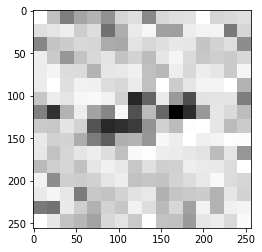

In [107]:
plt.imshow(embody(N, tiles_per_side, topInds[0]), cmap='binary')

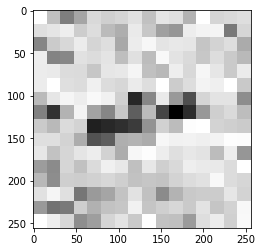

In [108]:
plt.imshow(embody(N, tiles_per_side, population[2]), cmap='binary', vmin=0)

In [37]:
compare_ssim(embody(N, tiles_per_side, population[0]), embody(N, tiles_per_side, population[1]))

0.3014995426842606

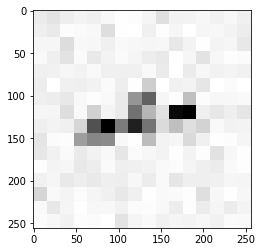

In [1061]:
plt.imshow(embody(N, tiles_per_side, genetic_code=topInds[0]), cmap='binary')

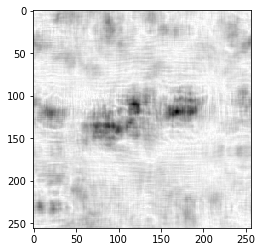

In [109]:
plt.imshow(abs(ft_sh_phase_screen(embody(N, tiles_per_side, genetic_code=topInds[0]), 
            phz_params_dict=phz_params_dict, genetic_code=None)), cmap='binary', vmin=0)

In [111]:
def generate_individual_from_code(N, tiles_per_side, original_tiles_per_side, genetic_code):
    
    if 0 == tiles_per_side / original_tiles_per_side % 2:
        pass
    else:
        return None
    
    original_tile_indices = generate_tile_indices(N, tiles_per_side=original_tiles_per_side)
    new_tile_indices = generate_tile_indices(N, tiles_per_side=tiles_per_side)
    new_genetic_code = [0 for x in new_tile_indices]
    
    for ntidx in range(len(new_tile_indices)):
        for otidx in range(len(original_tile_indices)):
            (x1o, x2o), (y1o, y2o) = original_tile_indices[otidx]
            (x1n, x2n), (y1n, y2n) = new_tile_indices[ntidx]
            
            if x1n >= x1o and x1n <= x2o:
                if x2n >= x1o and x2n <= x2o:
                    if y1n >= y1o and y1n <= y2o:
                        if y2n >= y1o and y2n <= y2o:
                            new_genetic_code[ntidx] = genetic_code[otidx]
                            continue
        
    return new_genetic_code

In [112]:
population32 = []
for idx in range(len(population)):
    nind = generate_individual_from_code(256, 32, 16, genetic_code=population[idx])
    population32.append(nind)

In [121]:
N = 256
Nindividuals = 100
tiles_per_side = 32
elitism = 0.1
Ntop = int(Nindividuals * elitism)
Ngenerations = 200
#population_orig = generate_orig_population(N, Nindividuals, tiles_per_side)

topLsesList = []
population32 = population32
for generation in range(Ngenerations):
    mutation_rate = 0.2 #(Ngenerations/(generation+1))-1
    area_affected = int((tiles_per_side**2)/16)
    start = time.time()
    topInds, topLses = pick_top_ii(N, tiles_per_side, population32, Ntop, Uout)
    population = generate_population_i(Nindividuals, topInds, topLses)
    population = mutate(population, mutation_rate=0.3, area_affected=area_affected)
    #population = mutate_i(population, mutation_rate=0.3, area_affected=area_affected)
    print(generation, time.time()-start, np.min(topLses), np.mean(topLses),
          np.median(topLses))#, np.log10(np.mean(topLses)))
    topLsesList.append(topLses)

0 41.096060276031494 47.39060037226208 49.504762046395825 49.551853546316465
1 29.03511619567871 45.992593849212035 48.9422993387006 49.469612531222715
2 28.140738010406494 46.765069847914596 49.19893396937666 49.37108977087966
3 27.397788047790527 46.81111828690664 50.09369157158554 50.41960779561937
4 28.752832174301147 45.32045766580247 48.663541245656894 49.305052575892745
5 28.254730939865112 46.49872079633732 50.14979452660862 50.74546343543828
6 27.476969957351685 45.95010608876844 48.842779133006886 49.04679862448475
7 29.660212993621826 47.21407984483247 49.39526897075103 49.07597768618274
8 56.46787881851196 43.75191133839979 48.80259985584121 49.33065887505686
9 40.83574032783508 47.75652828679174 50.430938514477404 50.65747022480594
10 29.83547306060791 43.90221613708794 48.83935794496922 49.236837242989665
11 28.17681312561035 47.880048247260184 50.1706620831307 49.96671429267839
12 28.73766589164734 46.121264216027996 49.30560993092841 49.47300715491388
13 28.674732923507

108 26.209886074066162 49.84557363484222 51.18073681217964 51.19711297813612
109 26.210193157196045 47.432551738652656 49.23577705339919 49.39835199169358
110 27.31910276412964 46.59146015450418 49.94616810431431 50.55805410976066
111 26.82536220550537 45.675199946698655 48.63003531034521 48.58371157593427
112 25.624899864196777 46.40077075216681 49.504280066555395 50.17120171493053
113 26.249212741851807 46.71879127186018 49.3820555364863 49.47705323718942
114 25.83539390563965 48.134896386649544 50.10683824734236 50.26994118517475
115 26.074059009552002 47.60866597062856 49.13181846854778 49.34168503967817
116 26.47757840156555 46.43328382200522 49.26167933398429 49.56895888378224
117 26.46355891227722 44.76031566099749 49.004334587242234 49.13304935494806
118 25.96857500076294 48.57731125423873 50.5545597710083 50.87899623420497
119 26.475154876708984 48.56756930892408 50.5885598769968 51.14094146781248
120 26.384204149246216 47.700426906166776 49.62005482757991 49.63051003394824
12

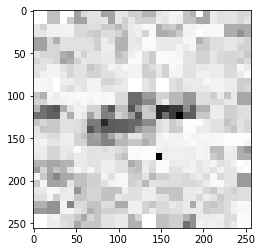

In [126]:
plt.imshow(embody(N, tiles_per_side=32, genetic_code=population[0]), cmap='binary')

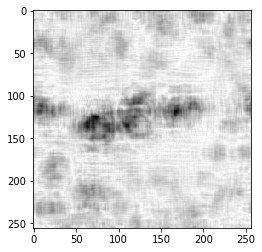

In [128]:
plt.imshow(abs(ft_sh_phase_screen(embody(N, tiles_per_side, genetic_code=topInds[0]), 
            phz_params_dict=phz_params_dict, genetic_code=None)), cmap='binary', vmin=0)

In [129]:
population64 = []
for idx in range(len(population)):
    nind = generate_individual_from_code(256, 64, 32, genetic_code=population[idx])
    population64.append(nind)

In [130]:
N = 256
Nindividuals = 100
tiles_per_side = 64
elitism = 0.1
Ntop = int(Nindividuals * elitism)
Ngenerations = 200
#population_orig = generate_orig_population(N, Nindividuals, tiles_per_side)

topLsesList = []
population64 = population64
for generation in range(Ngenerations):
    mutation_rate = 0.2 #(Ngenerations/(generation+1))-1
    area_affected = int((tiles_per_side**2)/16)
    start = time.time()
    topInds, topLses = pick_top_ii(N, tiles_per_side, population64, Ntop, Uout)
    population64 = generate_population_i(Nindividuals, topInds, topLses)
    population64 = mutate(population64, mutation_rate=0.3, area_affected=area_affected)
    #population = mutate_i(population, mutation_rate=0.3, area_affected=area_affected)
    print(generation, time.time()-start, np.min(topLses), np.mean(topLses),
          np.median(topLses))#, np.log10(np.mean(topLses)))
    topLsesList.append(topLses)

0 31.27316403388977 50.217697234935315 52.22690852981242 52.22875165760777
1 30.92103099822998 51.74709460846468 53.50427023964592 53.62466103731654
2 31.38385510444641 50.04562825788323 54.64299195063586 55.29363299257829
3 31.26548409461975 51.73941043740283 53.250919631086774 53.516215921589556
4 31.660260677337646 53.96134719567985 54.99023073918647 55.00393899627884
5 31.7175190448761 51.56757360817933 54.755393616923755 54.53720980496809
6 31.607133865356445 51.97445697296968 54.178633502782304 54.24693455823305
7 32.29549598693848 51.0712977571641 53.95130301882658 54.12211979397337
8 31.866841793060303 53.99117755478946 56.20744725291327 56.36241772086168
9 32.37391901016235 51.04179323459241 54.72976713978212 55.07873874316026
10 32.592779874801636 49.663929010524654 53.49742589885341 54.10676327965822
11 32.88311505317688 50.66550568407703 53.736312080972496 54.45676188367554
12 31.92784881591797 53.18564291975119 54.85553331684207 54.814163852319396
13 32.40381908416748 53.2

108 29.577636241912842 54.784206249153854 56.682435675191286 56.50558888253886
109 29.613255739212036 53.27080117989654 55.7475593639514 55.82330764022102
110 29.49312472343445 51.55531905981562 55.96445499051441 56.404651823912104
111 29.380436897277832 56.05398807024175 56.717606897459724 56.54181269326491
112 30.029974222183228 52.17431032493434 54.190498353799384 53.91883947647477
113 29.414854288101196 51.12662386172596 54.70981426636581 54.794547341576745
114 29.39658808708191 53.0966684480334 55.23160410816338 55.97472287130155
115 29.3751962184906 53.80483295644264 55.378787951069434 55.606861750066955
116 29.726348876953125 54.715273149754864 55.7934134315939 55.89517399387276
117 29.457398891448975 53.34301795882429 55.639425742234906 55.76517367122596
118 29.4813289642334 50.12678158270573 53.386659985120424 53.931292410901385
119 31.041235208511353 52.68770138486648 54.61684445853895 55.085766452156946
120 29.271270036697388 51.59815004501848 54.30474559611959 54.7566508980

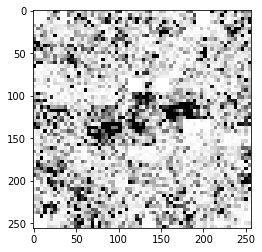

In [134]:
plt.imshow(embody(N, tiles_per_side=64, genetic_code=population64[0]), cmap='binary', vmin=0, vmax=255)

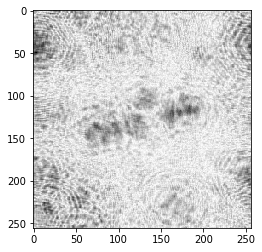

In [132]:
plt.imshow(abs(ft_sh_phase_screen(embody(N, tiles_per_side, genetic_code=population64[0]), 
            phz_params_dict=phz_params_dict, genetic_code=None)), cmap='binary', vmin=0)

In [1152]:
population128 = []
for idx in range(len(population)):
    nind = generate_individual_from_code(256, 128, 64, genetic_code=population64[idx])
    population128.append(nind)

In [1161]:
N = 256
Nindividuals = 100
tiles_per_side = 128
elitism = 0.1
Ntop = int(Nindividuals * elitism)
Ngenerations = 400

topLsesList = []
population128 = population128
for generation in range(Ngenerations):
    mutation_rate = 0.2 #(Ngenerations/(generation+1))-1
    area_affected = int((tiles_per_side**2)/16)
    start = time.time()
    topInds, topLses = pick_top_i(N, tiles_per_side, population128, Ntop, Uout)
    population128 = generate_population_ii(Nindividuals, topInds, topLses)
    population128 = mutate(population128, mutation_rate=mutation_rate,
                          area_affected=area_affected)
    print(generation, time.time()-start, np.min(topLses), np.mean(topLses),
          np.median(topLses), np.log10(np.mean(topLses)))
    topLsesList.append(topLses)

0 58.41860914230347 996.2861368040941 1018.1357633595775 1014.2405473940398 3.0078056928795585
1 49.252801179885864 1004.9446777169737 1034.0007490684952 1038.9802800626535 3.014520853377069
2 48.04091429710388 1001.7252380008147 1027.251657994907 1031.263633825871 3.0116768508903053
3 45.128233909606934 1021.4054730671613 1039.3115886447235 1042.8131566028628 3.0167457698306617
4 45.87055587768555 987.1499094340895 1023.1558156514908 1027.338166148953 3.009941777138042
5 46.843432903289795 990.8994000930415 1012.1472335048193 1010.3166473346612 3.0052436923928205
6 46.69349122047424 1000.8014610918602 1022.697429824678 1022.9916005738801 3.0097471645098497
7 46.57875084877014 997.6306207449496 1010.7004429316663 1009.5415874651846 3.004622456027028
8 51.936967849731445 987.7950845406866 1026.7007677644096 1035.403793868809 3.011443886786584
9 54.88706731796265 980.5763672220603 1014.3157541497761 1015.2576544767123 3.006173170912998
10 55.638477087020874 1005.3304288673756 1036.542909

86 48.78060007095337 1119.4560424605756 1146.5162362424708 1151.2914936808647 3.0593802093150493
87 46.08098912239075 1127.8099891671277 1157.0889245199946 1159.2630613273363 3.0633667366045696
88 44.838943004608154 1124.4956547476847 1148.9086745827594 1154.4212254618074 3.0602855084958818
89 42.37967324256897 1135.9730357411609 1155.6790571325012 1157.8657879906114 3.062837243194675
90 42.52967405319214 1130.40986028953 1170.0567236802167 1178.9332228914795 3.0682069166044195
91 42.89479088783264 1104.2615965785924 1159.3870598553021 1172.9899939096363 3.064228448816537
92 44.59898114204407 1158.8811391392014 1173.4911867356248 1175.992801618913 3.0694798322674117
93 45.4470100402832 1157.1449897835146 1171.4026303021426 1171.4026766924108 3.068706194870722
94 45.90550088882446 1110.8876020030548 1147.766237993282 1152.6050156702322 3.059853445651515
95 53.674448013305664 1142.3600806424772 1168.8568670611983 1176.2508505218348 3.067761332674779
96 55.8329119682312 1143.1796661734315

171 36.91016483306885 1166.7725778794627 1184.9360263032981 1183.7753617138371 3.073694903786247
172 37.312238931655884 1172.713546613323 1189.722802118747 1189.930493335146 3.0754457853138204
173 36.91369700431824 1161.8449720327055 1188.453572339658 1190.8926452996063 3.0749822204179775
174 36.938416957855225 1165.026320889166 1178.6198078211285 1176.7187841148402 3.0713737355501776
175 37.57195019721985 1136.859324241471 1175.273790181113 1181.4293237275851 3.070139051044982
176 39.742363929748535 1148.8488868239654 1178.7532185151456 1186.2106298249041 3.0714228915621056
177 36.47514486312866 1123.1410620135746 1174.1359982653241 1181.8945499333688 3.0697184034494525
178 35.926979064941406 1140.0821052235826 1173.1248223215878 1175.310893940687 3.069344224188322
179 36.49535083770752 1145.4561809460076 1171.718576530267 1175.2614741316615 3.0688233153200475
180 37.73289203643799 1146.0424212215037 1179.782032956851 1182.56303696953 3.071801777960344
181 37.14840817451477 1174.01352

256 38.111597776412964 1156.9080591563377 1189.2010084214394 1197.9742989646063 3.075255268807102
257 36.9505341053009 1149.6276893839029 1178.1616828428214 1183.0176979768203 3.0712048941421854
258 36.93240237236023 1167.7827443329752 1184.4603679774505 1185.9886473532133 3.0735205338163585
259 37.68166208267212 1164.1653514075665 1179.8608641249457 1179.0030177767635 3.071830795860773
260 36.711994886398315 1157.755599348508 1189.8885422187768 1190.566763562345 3.075506282597262
261 36.918097734451294 1175.0380937069717 1188.9975627724566 1189.513156827953 3.075180964395346
262 37.042569160461426 1151.1442251399815 1176.3828929152783 1176.4464800298333 3.0705487003245624
263 36.30021405220032 1153.9912263561876 1175.9881963400871 1181.291116163603 3.0704029626499043
264 38.094276905059814 1167.7234763808844 1190.0071173715776 1190.529102073032 3.0755495588933357
265 37.217926025390625 1158.6681739632802 1185.111652029025 1189.6550422827609 3.073759268131657
266 36.56255793571472 1165

341 37.764086961746216 1185.8065382668437 1218.547263550859 1220.9586043981512 3.085842378741304
342 36.61891412734985 1179.408268296123 1225.2366274901028 1231.8889484758722 3.088219971222251
343 36.80199694633484 1207.7942374632876 1226.1618523878558 1230.6292064322638 3.0885478004919453
344 37.463773012161255 1186.7465942909305 1209.6950486696 1210.1634249639465 3.082675903067
345 36.63381004333496 1196.0638232064125 1208.7714621430878 1207.8564875488987 3.082344198203831
346 36.55565071105957 1197.7203849628409 1226.6326327704314 1227.844482597197 3.0887145142758263
347 36.06474423408508 1199.1620139727834 1223.3352142062718 1219.9297177663134 3.0875454772589475
348 36.759443044662476 1185.7084591745627 1216.1038943789713 1219.890918048119 3.0849706792361005
349 36.22848987579346 1205.553129082832 1225.3049487957674 1226.5571560657615 3.0882441875557682
350 37.15224885940552 1211.4354459475692 1232.824772480864 1229.488528505374 3.090901352546549
351 37.155779123306274 1193.8309468

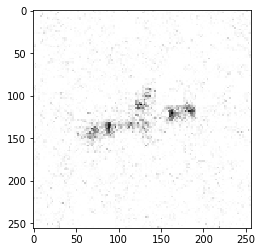

In [1164]:
plt.imshow(embody(N, tiles_per_side=128, genetic_code=population128[10]), cmap='binary')

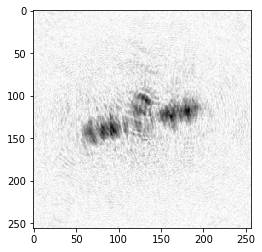

In [1165]:
plt.imshow(abs(ft_sh_phase_screen(embody(N, tiles_per_side, genetic_code=population128[10]), 
            phz_params_dict=phz_params_dict, genetic_code=None)), cmap='binary', vmin=0)